In [1]:
! git clone https://github.com/KulkarniKaustubh/PokeGAN.git

Cloning into 'PokeGAN'...
remote: Enumerating objects: 831, done.
remote: Counting objects: 100% (831/831), done.
remote: Compressing objects: 100% (829/829), done.
remote: Total 831 (delta 1), reused 828 (delta 1), pack-reused 0
Receiving objects: 100% (831/831), 39.42 MiB | 19.02 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [2]:
import numpy as np
import os
import cv2
import tensorflow as tf
import tensorflow.keras as K
import tensorflow.keras.layers as layers
import matplotlib.pyplot as plt

%matplotlib inline

In [56]:
DATA_PATH = 'PokeGAN/pokemon'
imageSize = 256

# getting training data
X_train = []

numImages = 0
for image in os.listdir(DATA_PATH):
    numImages += 1
    readImage = cv2.imread(os.path.join(DATA_PATH, image))
    readImage = cv2.resize(readImage, (imageSize, imageSize))
    # readImage = cv2.cvtColor(readImage, cv2.COLOR_BGR2GRAY)
    # readImage = np.expand_dims(readImage, axis=-1)
    X_train.append(readImage)

X_train = np.array(X_train).astype('float32')

# normalizing
X_train = (X_train-127.5)/127.5

print(X_train.shape)

(819, 256, 256, 3)


In [57]:
# 819 images of size (200, 200) with 1 channel
print(X_train.shape)

BUFFER = X_train.shape[0]
BATCH_SIZE = 16

trainingData = tf.data.Dataset.from_tensor_slices(X_train).shuffle(BUFFER).batch(BATCH_SIZE)

# just to check dimension
lst = list(trainingData.as_numpy_iterator())
print(len(lst))
print(len(lst[0]))
print(len(lst[-1]))
print(len(lst[0][0]))
print(len(lst[0][0][0]))
print(len(lst[0][0][0][0]))

(819, 256, 256, 3)
52
16
3
256
256
3


# Models

- Discriminator model
- Generator model

In [70]:
K.backend.clear_session()

def getDiscriminatorModel():
    model = K.models.Sequential([
        layers.Conv2D(64, (3, 3), padding = 'same', input_shape = (imageSize, imageSize, 3)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        
        layers.Conv2D(128, (5, 5), strides = (2, 2), padding = 'same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        
        layers.Conv2D(256, (5, 5), strides = (2, 2), padding = 'same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2D(512, (5, 5), strides = (2, 2), padding = 'same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        
        layers.Flatten(),
        layers.Dense(1),
    ])
    
    return model

In [71]:
discriminator = getDiscriminatorModel()

In [72]:
discriminator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 64)      1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 64)      256       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256, 256, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 128)     204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 128)     512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128, 128, 128)     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 256)       8

In [73]:
# from the summary above, we see that we get a 7x7x128 just before flattenning
nodes = 32*32*512
noiseDim = 100

def getGeneratorModel():
    model = K.models.Sequential([
        layers.Dense(nodes, input_shape = (noiseDim,)),
        # shouldn't explode
        layers.BatchNormalization(),
        layers.Reshape((32, 32, 512)),
        layers.LeakyReLU(),
        
        layers.Conv2DTranspose(512, (5, 5), padding = 'same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        
        layers.Conv2DTranspose(256, (5, 5), strides = (2, 2), padding = 'same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        
        layers.Conv2DTranspose(128, (5, 5), padding = 'same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(64, (5, 5), strides = (2, 2), padding = 'same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(32, (5, 5), strides = (2, 2), padding = 'same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        
        # at this point the image is upsampled twice so we have 7*2*2 shaped image
        layers.Conv2DTranspose(3, (3, 3), padding = 'same')
    ])
    
    return model

In [74]:
generator = getGeneratorModel()

In [75]:
generator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 524288)            52953088  
_________________________________________________________________
batch_normalization_4 (Batch (None, 524288)            2097152   
_________________________________________________________________
reshape (Reshape)            (None, 32, 32, 512)       0         
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 32, 32, 512)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 32, 32, 512)       6554112   
_________________________________________________________________
batch_normalization_5 (Batch (None, 32, 32, 512)       2048      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 32, 32, 512)      

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 256, 256, 3)


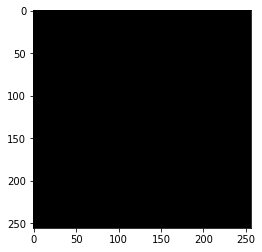

In [76]:
# testing the generator with some noise
noise = tf.random.normal([1, noiseDim])
genImgs = generator(noise, training = False)
print(genImgs.shape)
plt.imshow(genImgs[0, :, :, :])

In [77]:
decision = discriminator(genImgs)
print(decision)

tf.Tensor([[5.4894677e-05]], shape=(1, 1), dtype=float32)


# Optimizers

In [78]:
genOpt = K.optimizers.Adam(lr = 1e-4)
discOpt = K.optimizers.Adam(lr = 1e-4)

# Losses

In [79]:
def getGeneratorLoss(fakePreds):
    return K.losses.BinaryCrossentropy()(tf.ones_like(fakePreds), fakePreds)

In [80]:
def getDiscriminatorLoss(realPreds, fakePreds):
    rLoss = K.losses.BinaryCrossentropy()(tf.ones_like(realPreds), realPreds)
    fLoss = K.losses.BinaryCrossentropy()(tf.zeros_like(fakePreds), fakePreds)
    totalLoss = rLoss + fLoss
    return totalLoss

# Training

In [81]:
EPOCHS = 50

In [82]:
def train(dataset, epochs):
    gLoss = None
    dLoss = None
    for epoch in range(epochs):
        print("Running epoch : " + str(epoch + 1))
        
        for pokemon in dataset:
            gLoss, dLoss = trainStep(pokemon)
        
        if (epoch+1)%5 == 0:
          print("GEN Loss: " + str(gLoss))
          print("DISC Loss: " + str(dLoss))

In [83]:
# this decorator is used to input to the tensorflow graph
@tf.function
def trainStep(images):
    noise = tf.random.normal([BATCH_SIZE, 100])
    
    with tf.GradientTape() as gen, tf.GradientTape() as disc:
        genImages = generator(noise, training = True)
        
        realOP = discriminator(images, training = True)
        fakeOP = discriminator(genImages, training = True)
        
        genLoss = getGeneratorLoss(fakeOP)
        discLoss = getDiscriminatorLoss(realOP, fakeOP)
        
    genGrads = gen.gradient(genLoss, generator.trainable_variables)
    discGrads = disc.gradient(discLoss, discriminator.trainable_variables)
    
    genOpt.apply_gradients(zip(genGrads, generator.trainable_variables))
    discOpt.apply_gradients(zip(discGrads, discriminator.trainable_variables))

    return genLoss, discLoss

In [84]:
train(trainingData, EPOCHS)

Running epoch : 1
Running epoch : 2
Running epoch : 3
Running epoch : 4
Running epoch : 5
GEN Loss: tf.Tensor(15.424949, shape=(), dtype=float32)
DISC Loss: tf.Tensor(-0.0, shape=(), dtype=float32)
Running epoch : 6
Running epoch : 7
Running epoch : 8
Running epoch : 9
Running epoch : 10
GEN Loss: tf.Tensor(15.424949, shape=(), dtype=float32)
DISC Loss: tf.Tensor(-0.0, shape=(), dtype=float32)
Running epoch : 11
Running epoch : 12
Running epoch : 13
Running epoch : 14
Running epoch : 15
GEN Loss: tf.Tensor(15.424949, shape=(), dtype=float32)
DISC Loss: tf.Tensor(-0.0, shape=(), dtype=float32)
Running epoch : 16
Running epoch : 17
Running epoch : 18
Running epoch : 19
Running epoch : 20
GEN Loss: tf.Tensor(15.424949, shape=(), dtype=float32)
DISC Loss: tf.Tensor(-0.0, shape=(), dtype=float32)
Running epoch : 21
Running epoch : 22
Running epoch : 23
Running epoch : 24
Running epoch : 25
GEN Loss: tf.Tensor(15.424949, shape=(), dtype=float32)
DISC Loss: tf.Tensor(-0.0, shape=(), dtype=flo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


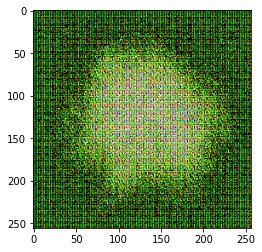

In [89]:
genImg = generator(tf.random.normal([1, noiseDim]))
plt.imshow(genImg[0, :, :, :])